# Halpha Emitters S-PLUS

In [99]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap.umap_ as umap
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

In [100]:
combined_df = pd.read_csv("../Ha-emitters/Halpha_Mine_PerField_total-unique_wise.csv")
combined_df

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0000,0,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,0000,1,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,hh00,0,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,0000,0,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0000,0,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,b'SPLUS-s36s37',b'iDR4_3_SPLUS-s36s37_0025901',71.106998,-46.341673,2462.8843,7649.7290,0.000412,0.906635,8.169368e-07,4.459435,...,0000,0,00nn,AAUU,570.0,236.0,-341.0,243.0,0.143,0.287296
3169,b'SPLUS-s36s38',b'iDR4_3_SPLUS-s36s38_0030320',72.844397,-46.547450,3460.8180,6309.8390,0.000254,0.901617,4.434800e-07,3.425591,...,0000,0,0nnn,ABUU,570.0,427.0,-212.0,446.0,NaN,0.404539
3170,b'SPLUS-s37s20',b'iDR4_3_SPLUS-s37s20_0018970',36.986249,-47.979777,9942.3110,5415.3390,0.000337,0.947522,4.901620e-07,3.348765,...,0000,0,1nnn,AABU,-440.0,538.0,497.0,532.0,NaN,0.165798
3171,b'SPLUS-s37s28',b'iDR4_3_SPLUS-s37s28_0010068',53.578866,-48.279839,7334.9710,3475.4363,0.000474,0.994518,7.002315e-07,3.863218,...,0000,0,nnnn,ABUU,-423.0,513.0,-262.0,511.0,NaN,0.625503


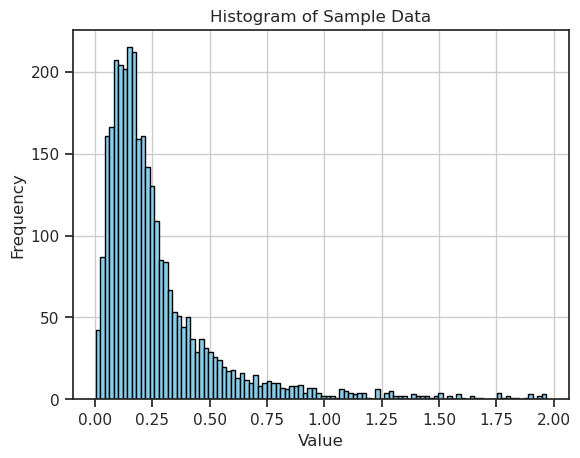

In [101]:
# See the distance of the SPLUS nad WISE source
# Plotting the histogram
plt.hist(combined_df["angDist"], bins=100, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [102]:
for columns in combined_df.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf
AllWISE
RAJ2000
DEJ2000
eeMaj
eeMin
eePA
W1mag
W2

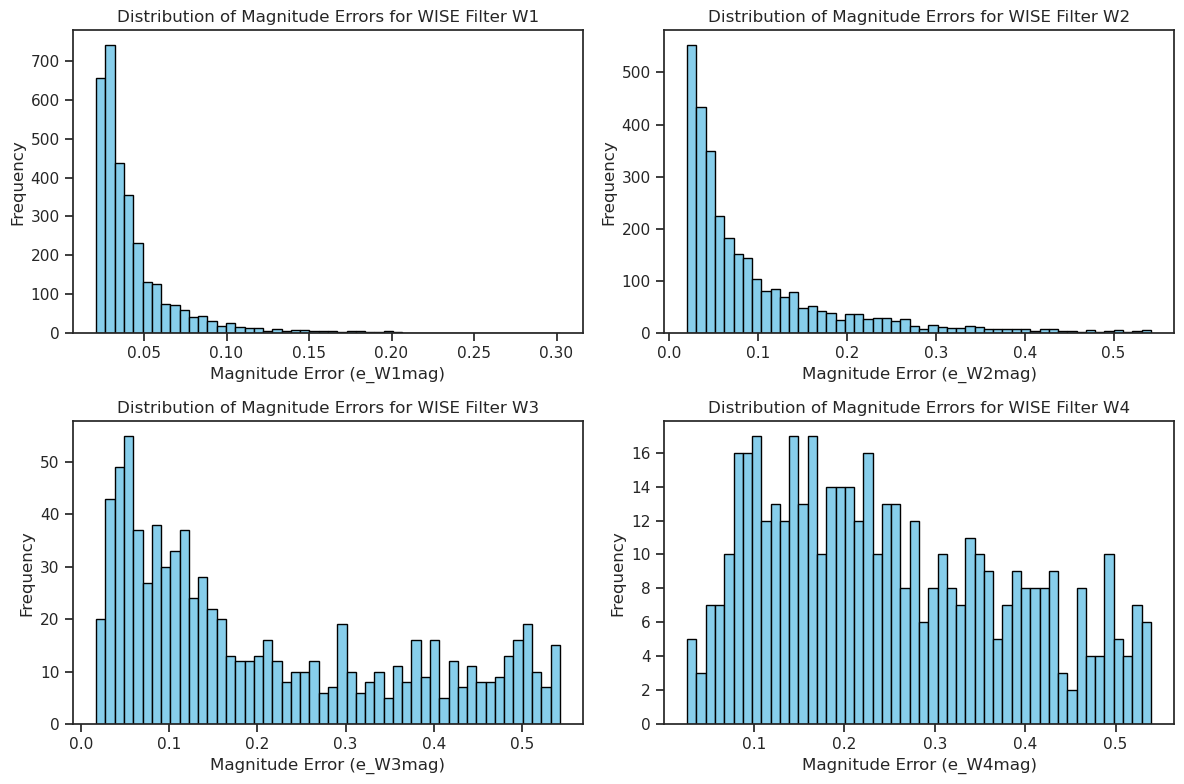

In [103]:
# Extract magnitude errors for WISE filters W1, W2, W3, W4
magnitude_errors_w1 = combined_df["e_W1mag"]
magnitude_errors_w2 = combined_df["e_W2mag"]
magnitude_errors_w3 = combined_df["e_W3mag"]
magnitude_errors_w4 = combined_df["e_W4mag"]

# Create subplots for each histogram
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for e_W1mag
axs[0, 0].hist(magnitude_errors_w1, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Magnitude Errors for WISE Filter W1')
axs[0, 0].set_xlabel('Magnitude Error (e_W1mag)')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for e_W2mag
axs[0, 1].hist(magnitude_errors_w2, bins=50, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of Magnitude Errors for WISE Filter W2')
axs[0, 1].set_xlabel('Magnitude Error (e_W2mag)')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for e_W3mag
axs[1, 0].hist(magnitude_errors_w3, bins=50, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of Magnitude Errors for WISE Filter W3')
axs[1, 0].set_xlabel('Magnitude Error (e_W3mag)')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for e_W4mag
axs[1, 1].hist(magnitude_errors_w4, bins=50, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of Magnitude Errors for WISE Filter W4')
axs[1, 1].set_xlabel('Magnitude Error (e_W4mag)')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [104]:
# Cleaned error

m_err_splus = (combined_df["e_r_PStotal"] <= 0.2) & (combined_df["e_g_PStotal"] <= 0.2) & \
        (combined_df["e_i_PStotal"] <= 0.2) & (combined_df["e_u_PStotal"] <= 0.2) & \
        (combined_df["e_J0378_PStotal"] <= 0.2) & (combined_df["e_J0395_PStotal"] <= 0.2) & \
        (combined_df["e_J0410_PStotal"] <= 0.2) & (combined_df["e_J0430_PStotal"] <= 0.2) & \
        (combined_df["e_J0515_PStotal"] <= 0.2) & (combined_df["e_J0660_PStotal"] <= 0.2) & \
        (combined_df["e_J0861_PStotal"] <= 0.2) & (combined_df["e_z_PStotal"] <= 0.2)

# Choose a threshold for the maximum allowed magnitude error
max_allowed_e_Wmag = 0.5  # Example threshold value

# Apply the threshold to filter the dataset

m_err_wise = (combined_df["e_W1mag"] <= max_allowed_e_Wmag) & \
              (combined_df["e_W2mag"] <= max_allowed_e_Wmag) 
        

mask_total = (m_err_splus & m_err_wise)

In [105]:
df_cleanErr = combined_df[mask_total]
len(df_cleanErr)

1910

In [106]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [107]:
df_mag = df_cleanErr[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,14.816056,14.486720
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,12.990587,12.979302
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,14.003431,13.810323
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,14.518179,14.313604
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,15.035774,15.058778
...,...,...,...,...,...,...,...,...,...,...,...,...
3160,18.984863,19.173277,18.961775,19.165236,19.029478,19.125818,19.073740,19.428220,19.064045,19.175116,18.582588,19.076565
3161,19.145393,19.392807,19.149042,19.483732,19.253126,19.356201,19.512580,19.604906,19.255878,19.327562,18.813627,19.175780
3162,18.997220,19.362211,18.969034,19.292204,19.017313,19.161670,19.300804,19.485540,19.302265,19.389957,18.749697,18.949018
3163,18.725367,19.163845,18.704376,19.225578,18.807562,19.013613,19.267433,19.221233,19.091179,19.116653,18.410843,18.612427


## Creating the colors

In [10]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [11]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [12]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_578178/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_578178/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_578178/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [13]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,18.984863,19.173277,18.961775,19.165236,19.029478,19.125818,19.073740,19.428220,19.064045,19.175116,...,0.364175,0.253104,0.845632,0.351655,-0.111071,0.481457,-0.012520,0.592528,0.098551,-0.493977
3161,19.145393,19.392807,19.149042,19.483732,19.253126,19.356201,19.512580,19.604906,19.255878,19.327562,...,0.349028,0.277344,0.791279,0.429126,-0.071684,0.442251,0.080098,0.513935,0.151782,-0.362153
3162,18.997220,19.362211,18.969034,19.292204,19.017313,19.161670,19.300804,19.485540,19.302265,19.389957,...,0.183275,0.095583,0.735843,0.536522,-0.087692,0.552568,0.353247,0.640260,0.440939,-0.199321
3163,18.725367,19.163845,18.704376,19.225578,18.807562,19.013613,19.267433,19.221233,19.091179,19.116653,...,0.130054,0.104580,0.810390,0.608806,-0.025474,0.680336,0.478752,0.705810,0.504226,-0.201584


In [14]:
# Drop magnitudes
df_colors = df_colors_mag.drop(columns=columns)

In [15]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,-0.188414,0.023088,-0.180373,-0.044615,-0.140955,-0.088877,-0.443357,-0.079182,-0.190253,0.402275,...,0.364175,0.253104,0.845632,0.351655,-0.111071,0.481457,-0.012520,0.592528,0.098551,-0.493977
3161,-0.247414,-0.003649,-0.338339,-0.107733,-0.210808,-0.367187,-0.459513,-0.110485,-0.182169,0.331766,...,0.349028,0.277344,0.791279,0.429126,-0.071684,0.442251,0.080098,0.513935,0.151782,-0.362153
3162,-0.364991,0.028186,-0.294984,-0.020093,-0.164450,-0.303584,-0.488320,-0.305045,-0.392737,0.247523,...,0.183275,0.095583,0.735843,0.536522,-0.087692,0.552568,0.353247,0.640260,0.440939,-0.199321
3163,-0.438478,0.020991,-0.500211,-0.082195,-0.288246,-0.542066,-0.495866,-0.365812,-0.391286,0.314524,...,0.130054,0.104580,0.810390,0.608806,-0.025474,0.680336,0.478752,0.705810,0.504226,-0.201584


### Making the color using some WISE filters

In [16]:
# Calculate differences between W1 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W1_{col}'] = df_cleanErr["W1mag"] - df_cleanErr[col]

# Calculate differences between W2 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W2_{col}'] = df_cleanErr["W2mag"] - df_cleanErr[col]


In [17]:
# Calculate difference between W1 and W2
df_colors['diff_W1_W2'] = df_cleanErr['W1mag'] - df_cleanErr['W2mag']

In [18]:
for columns in df_colors.columns:
    print(columns)

r_PStotal - g_PStotal
r_PStotal - i_PStotal
r_PStotal - u_PStotal
r_PStotal - z_PStotal
r_PStotal - J0378_PStotal
r_PStotal - J0395_PStotal
r_PStotal - J0410_PStotal
r_PStotal - J0430_PStotal
r_PStotal - J0515_PStotal
r_PStotal - J0660_PStotal
r_PStotal - J0861_PStotal
g_PStotal - i_PStotal
g_PStotal - u_PStotal
g_PStotal - z_PStotal
g_PStotal - J0378_PStotal
g_PStotal - J0395_PStotal
g_PStotal - J0410_PStotal
g_PStotal - J0430_PStotal
g_PStotal - J0515_PStotal
g_PStotal - J0660_PStotal
g_PStotal - J0861_PStotal
i_PStotal - u_PStotal
i_PStotal - z_PStotal
i_PStotal - J0378_PStotal
i_PStotal - J0395_PStotal
i_PStotal - J0410_PStotal
i_PStotal - J0430_PStotal
i_PStotal - J0515_PStotal
i_PStotal - J0660_PStotal
i_PStotal - J0861_PStotal
u_PStotal - z_PStotal
u_PStotal - J0378_PStotal
u_PStotal - J0395_PStotal
u_PStotal - J0410_PStotal
u_PStotal - J0430_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
u_PStotal - J0861_PStotal
z_PStotal - J0378_PStotal
z_PStotal - J0395_PStotal


In [19]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,diff_W1_g_PStotal,diff_W1_i_PStotal,diff_W1_u_PStotal,diff_W1_z_PStotal,diff_W2_r_PStotal,diff_W2_g_PStotal,diff_W2_i_PStotal,diff_W2_u_PStotal,diff_W2_z_PStotal,diff_W1_W2
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,-3.450457,-2.091934,-5.786275,-1.868712,-2.496734,-3.447457,-2.088934,-5.783275,-1.865712,-0.003
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,-1.251669,-1.094601,-2.628666,-1.130734,-1.052103,-1.225669,-1.068601,-2.602666,-1.104734,-0.026
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,-2.409924,-1.601414,-3.988249,-1.505016,-1.798063,-2.408924,-1.600414,-3.987249,-1.504016,-0.001
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,-2.507463,-1.640484,-4.366853,-1.557745,-1.900768,-2.519463,-1.652484,-4.378853,-1.569745,0.012
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,-1.763464,-1.407340,-3.147654,-1.352277,-1.302292,-1.695464,-1.339340,-3.079654,-1.284277,-0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,-0.188414,0.023088,-0.180373,-0.044615,-0.140955,-0.088877,-0.443357,-0.079182,-0.190253,0.402275,...,-3.693277,-3.481775,-3.685236,-3.549478,-4.934863,-5.123277,-4.911775,-5.115236,-4.979478,1.430
3161,-0.247414,-0.003649,-0.338339,-0.107733,-0.210808,-0.367187,-0.459513,-0.110485,-0.182169,0.331766,...,-3.877807,-3.634042,-3.968732,-3.738126,-4.927393,-5.174807,-4.931042,-5.265732,-5.035126,1.297
3162,-0.364991,0.028186,-0.294984,-0.020093,-0.164450,-0.303584,-0.488320,-0.305045,-0.392737,0.247523,...,-3.642211,-3.249034,-3.572204,-3.297313,-4.751220,-5.116211,-4.723034,-5.046204,-4.771313,1.474
3163,-0.438478,0.020991,-0.500211,-0.082195,-0.288246,-0.542066,-0.495866,-0.365812,-0.391286,0.314524,...,-4.062845,-3.603376,-4.124578,-3.706562,-4.902367,-5.340845,-4.881376,-5.402578,-4.984562,1.278


# Reduction dimensionality

In [20]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

In [21]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [22]:
# Define a range of number of components to try
n_components_range = [2, 3, 4, 5, 10, 20, 50]
n_neighbors_range = [5, 10, 15, 20, 30, 50, 70, 100]

# Initialize variables to store the best parameters
best_silhouette_score = -1
best_davies_bouldin_score = np.inf
best_num_components = None
best_n_neighbors = None
best_labels = None

In [98]:
# Loop over different numbers of components and neighbors
for num_components in n_components_range:
    for n_neighbors in n_neighbors_range:
        # Fit UMAP model
        reducer_ = umap.UMAP(n_neighbors=n_neighbors, n_components=num_components, random_state=42)
        X_train_trans = reducer_.fit_transform(X_train)

        # Cluster the transformed data using KMeans
        kmeans = KMeans(n_clusters=num_components, random_state=42)
        labels = kmeans.fit_predict(X_train_trans)

        # Evaluate performance using Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_train_trans, labels)
        davies_bouldin = davies_bouldin_score(X_train_trans, labels)
        print(f"Components: {num_components}, Neighbors: {n_neighbors}, Silhouette Score: {silhouette}, DB Index: {davies_bouldin}")

        # Update best parameters based on combined metrics
        if silhouette > best_silhouette_score and davies_bouldin < best_davies_bouldin_score:
            best_silhouette_score = silhouette
            best_davies_bouldin_score = davies_bouldin
            best_num_components = num_components
            best_n_neighbors = n_neighbors
            best_labels = labels

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin_score}")
print(f"Best Number of Components: {best_num_components}")
print(f"Best Number of Neighbors: {best_n_neighbors}")

/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 5, Silhouette Score: 0.6145757436752319, DB Index: 0.5500102422594765


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 10, Silhouette Score: 0.6545103192329407, DB Index: 0.4906314009614034


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 15, Silhouette Score: 0.7355569005012512, DB Index: 0.3663317811318255


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 20, Silhouette Score: 0.7237235903739929, DB Index: 0.38106563811338034


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 30, Silhouette Score: 0.7662748098373413, DB Index: 0.31520018223583013


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 50, Silhouette Score: 0.760275661945343, DB Index: 0.31975246201828467


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 70, Silhouette Score: 0.8117259740829468, DB Index: 0.24706680805543374


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 2, Neighbors: 100, Silhouette Score: 0.8584845066070557, DB Index: 0.18021416278895747


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 5, Silhouette Score: 0.5380954146385193, DB Index: 0.6278415868970085


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 10, Silhouette Score: 0.5810730457305908, DB Index: 0.5587920468086659


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 15, Silhouette Score: 0.5759674906730652, DB Index: 0.565791077903122


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 20, Silhouette Score: 0.5894997715950012, DB Index: 0.5456032646106913


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 30, Silhouette Score: 0.600283145904541, DB Index: 0.5304905813372908


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 50, Silhouette Score: 0.6248789429664612, DB Index: 0.49127982321257974


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 70, Silhouette Score: 0.6309167146682739, DB Index: 0.48284069707694427


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 3, Neighbors: 100, Silhouette Score: 0.6403724551200867, DB Index: 0.46587812069297846


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 5, Silhouette Score: 0.570408284664154, DB Index: 0.5460958761044667


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 10, Silhouette Score: 0.4986586570739746, DB Index: 0.6932352210980826


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 15, Silhouette Score: 0.49859607219696045, DB Index: 0.7213496320552286


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 20, Silhouette Score: 0.5298072099685669, DB Index: 0.6452293683093198


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 30, Silhouette Score: 0.535200834274292, DB Index: 0.6553128091134274


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 50, Silhouette Score: 0.5555523037910461, DB Index: 0.6197069828207753


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 70, Silhouette Score: 0.5671378970146179, DB Index: 0.6040337843902066


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 4, Neighbors: 100, Silhouette Score: 0.5768216252326965, DB Index: 0.5784771167844049


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 5, Silhouette Score: 0.5194632411003113, DB Index: 0.6836433922007799


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 10, Silhouette Score: 0.48261740803718567, DB Index: 0.6379843259008606


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 15, Silhouette Score: 0.44790181517601013, DB Index: 0.7096251026494631


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 20, Silhouette Score: 0.5214006304740906, DB Index: 0.6670428555834635


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 30, Silhouette Score: 0.49857279658317566, DB Index: 0.6047976015611827


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 50, Silhouette Score: 0.5168974995613098, DB Index: 0.6733526436514486


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 70, Silhouette Score: 0.5319150686264038, DB Index: 0.657377906293315


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 5, Neighbors: 100, Silhouette Score: 0.5402525067329407, DB Index: 0.6560981318309772


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 5, Silhouette Score: 0.5646010041236877, DB Index: 0.4584745379801679


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 10, Silhouette Score: 0.4813559055328369, DB Index: 0.6426734955108924


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 15, Silhouette Score: 0.5233010649681091, DB Index: 0.5533424710834935


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 20, Silhouette Score: 0.46325236558914185, DB Index: 0.6548882409199632


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 30, Silhouette Score: 0.48845210671424866, DB Index: 0.5996849187212001


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 50, Silhouette Score: 0.49385902285575867, DB Index: 0.6734917517629297


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 70, Silhouette Score: 0.4851837158203125, DB Index: 0.7280185495605851


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 10, Neighbors: 100, Silhouette Score: 0.48237890005111694, DB Index: 0.6953327656212175


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 5, Silhouette Score: 0.4861859083175659, DB Index: 0.7295231457485006


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 10, Silhouette Score: 0.4504479169845581, DB Index: 0.7660312916769734


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 15, Silhouette Score: 0.4724065959453583, DB Index: 0.6972856713234441


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 20, Silhouette Score: 0.469197541475296, DB Index: 0.7237621458482103


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 30, Silhouette Score: 0.4648189842700958, DB Index: 0.7087283641473662


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 50, Silhouette Score: 0.4703405499458313, DB Index: 0.7270935770898761


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 70, Silhouette Score: 0.4672047197818756, DB Index: 0.7495275665898677


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 20, Neighbors: 100, Silhouette Score: 0.4272904396057129, DB Index: 0.7418466216289225


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 5, Silhouette Score: 0.4625893235206604, DB Index: 0.7116399256091169


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 10, Silhouette Score: 0.4443456828594208, DB Index: 0.8135189844084856


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 15, Silhouette Score: 0.4539511799812317, DB Index: 0.757586278940615


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 20, Silhouette Score: 0.4365348517894745, DB Index: 0.8039881557959073


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 30, Silhouette Score: 0.41303879022598267, DB Index: 0.8407653009550038


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 50, Silhouette Score: 0.40137583017349243, DB Index: 0.8468450474555214


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 70, Silhouette Score: 0.3747898042201996, DB Index: 0.9120275166368091


/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Components: 50, Neighbors: 100, Silhouette Score: 0.3777092397212982, DB Index: 0.9116507301286881
Best Silhouette Score: 0.8584845066070557
Best Davies-Bouldin Index: 0.18021416278895747
Best Number of Components: 2
Best Number of Neighbors: 100


#### Try UMAP

In [68]:
num_components = 2
reducer = umap.UMAP(n_neighbors=50, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

/home/luisangel/.conda/envs/my_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [69]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

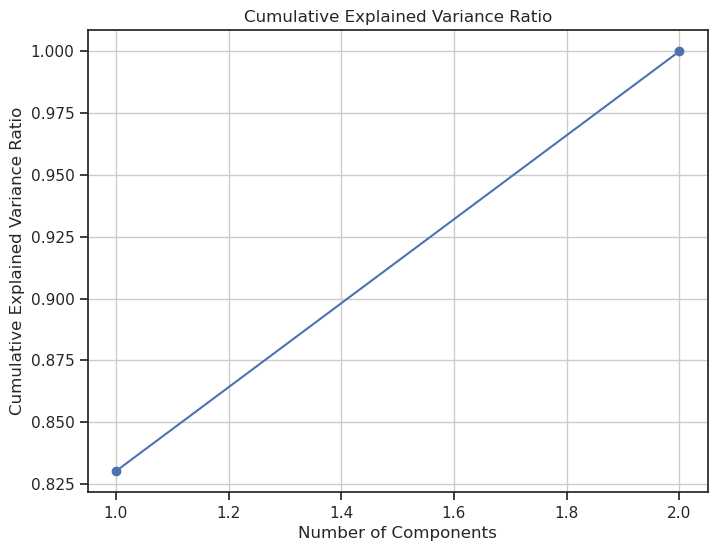

In [70]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [71]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,11.837363,3.213830
1,6.669079,9.683391
2,10.876542,5.822541
3,11.922624,5.332194
4,7.886585,9.159457
...,...,...
1905,-1.109960,10.880507
1906,-1.000614,10.869364
1907,-1.406410,10.543327
1908,-1.814237,10.382736


/tmp/ipykernel_578178/1329027073.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', 10))


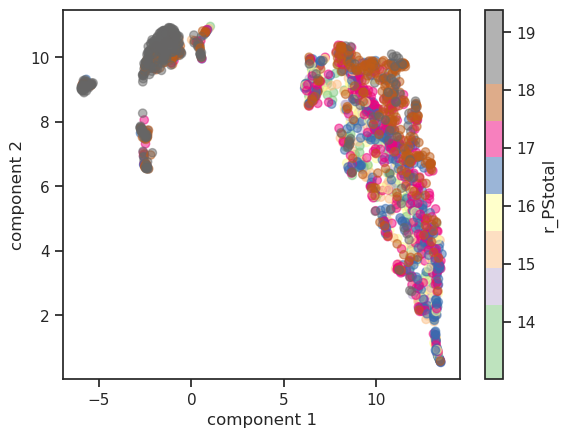

In [89]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r_PStotal"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r_PStotal')  # Set the label of the color bar to 'g_PStotal'
plt.show()

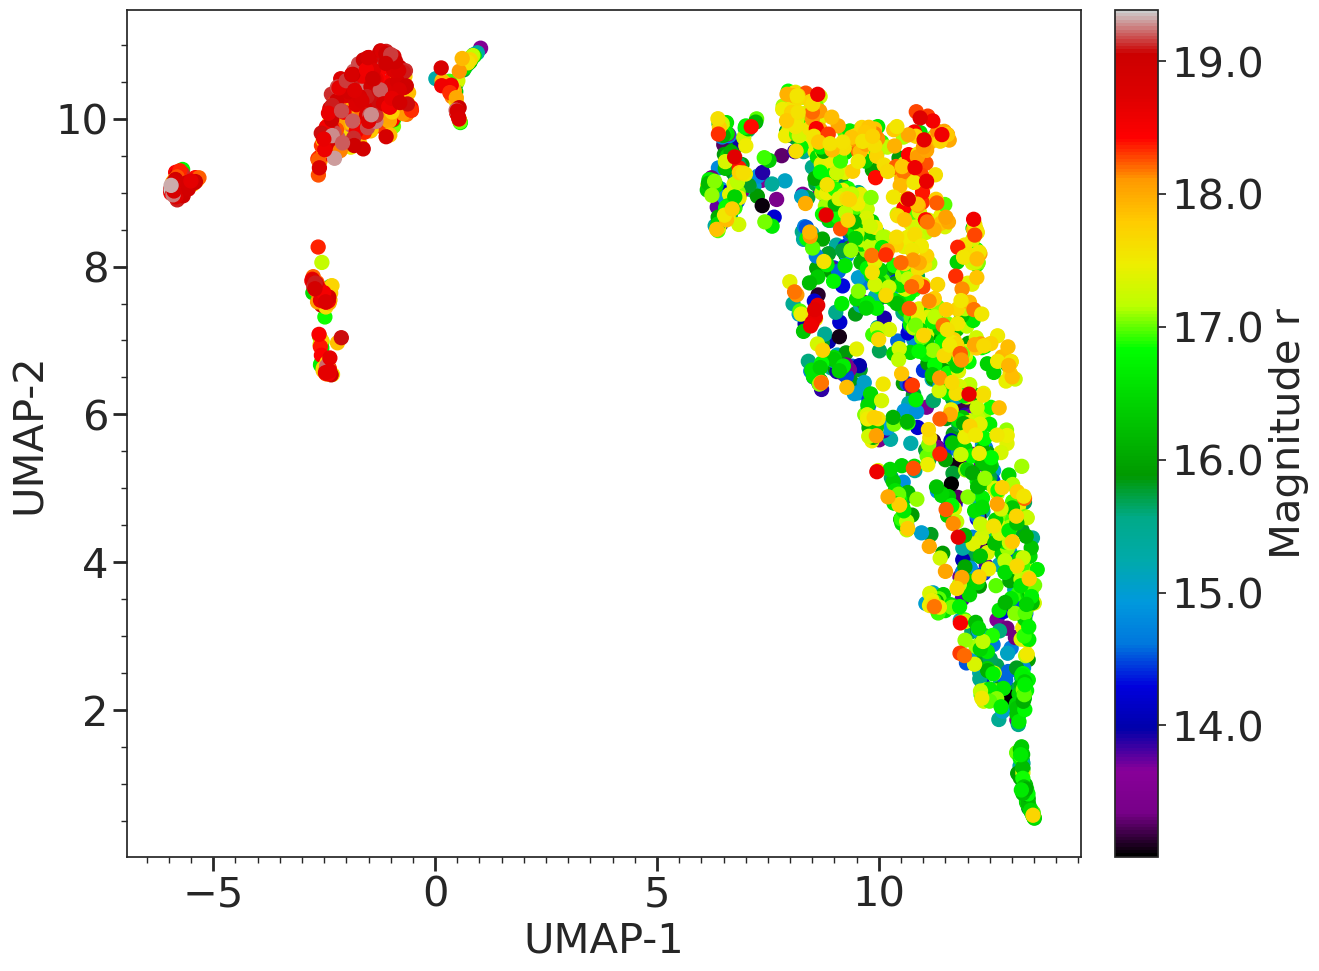

In [90]:
from matplotlib.ticker import MultipleLocator, NullFormatter

# Plotting
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.xlabel("UMAP-1", fontsize=30)
    plt.ylabel("UMAP-2", fontsize=30)
    plt.tick_params(axis='x', labelsize=30, width=2, length=10)  # Adjusting width of tick marks
    plt.tick_params(axis='y', labelsize=30, width=2, length=10)  # Adjusting width of tick marks

    # Create a scatter plot
    sc = ax.scatter(umap_df["PC1"], umap_df["PC2"], c=df_cleanErr["r_PStotal"], cmap="nipy_spectral", s=100)
    
    # Add minor tick locators without showing the minor ticks
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # Add a colorbar with improved visibility
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, format='%.1f')
    cbar.set_label("Magnitude r", fontsize=30)  # Provide a label for the colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust the size of the tick labels

#plt.savefig("../Figs/umap_splus_disk_wise.pdf")

In [91]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=50, 
                             prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [92]:
clusterer.fit(X_trans)
labels = clusterer.labels_
len(labels)

1910

In [93]:
clusterer.metric

'euclidean'

In [94]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [95]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of cluster points 0: 1437
Estimated number of cluster points 1: 59
Estimated number of cluster points 2: 94
Estimated number of cluster points 3: 51
Estimated number of noise points: 0


<Axes: xlabel='PC1', ylabel='PC2'>

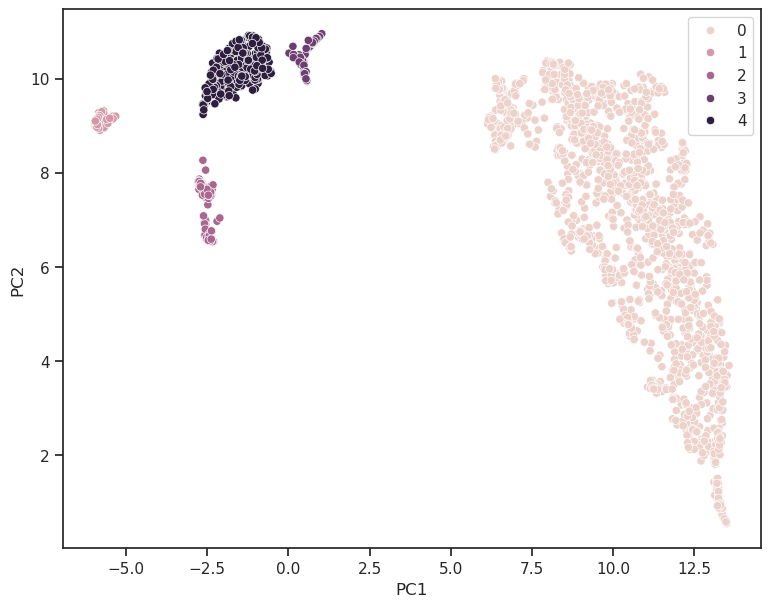

In [96]:
plt.figure(figsize=(9,7))
sns.scatterplot(x=umap_df["PC1"], y=umap_df["PC2"], 
                hue=labels,
                )

In [97]:
# Concatenat the original claen table with the umap results
df_cleanErr.reset_index(drop=True, inplace=True)
umap_df.reset_index(drop=True, inplace=True)
df_cleanErr_umap = pd.concat([df_cleanErr, umap_df], axis=1)
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist,PC1,PC2
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107,11.837363,3.213830
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308,6.669079,9.683391
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144,10.876542,5.822541
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241,11.922624,5.332194
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180,7.886585,9.159457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,b'SPLUS-s35s38',b'iDR4_3_SPLUS-s35s38_0020445',69.629488,-45.425429,9390.1890,5115.5120,0.000527,1.076820,1.050347e-06,4.056287,...,000n,BABB,83.0,207.0,204.0,212.0,NaN,0.266434,-1.109960,10.880507
1906,b'SPLUS-s35s39',b'iDR4_3_SPLUS-s35s39_0025252',71.439514,-45.425063,9825.4430,5113.0664,0.000390,0.913662,7.002315e-07,4.853277,...,00nn,AABU,66.0,217.0,182.0,224.0,NaN,0.051424,-1.000614,10.869364
1907,b'SPLUS-s35s40',b'iDR4_3_SPLUS-s35s40_0023505',74.481229,-45.428318,4602.3823,5115.9824,0.000389,1.049081,8.869599e-07,4.319926,...,00nn,AABC,236.0,238.0,-76.0,245.0,NaN,0.097466,-1.406410,10.543327
1908,b'SPLUS-s35s45',b'iDR4_3_SPLUS-s35s45_0012142',322.873032,-45.697343,9781.9830,3331.1182,0.000512,1.041100,9.336420e-07,3.945878,...,001n,AAAB,17.0,228.0,-193.0,229.0,NaN,0.412153,-1.814237,10.382736


In [87]:
df_cleanErr_umap["Label"] = labels
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist,PC1,PC2,Label
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,AACU,182.0,57.0,64.0,59.0,0.115,0.129107,11.837363,3.213830,0
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308,6.669079,9.683391,0
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144,10.876542,5.822541,0
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241,11.922624,5.332194,0
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180,7.886585,9.159457,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,b'SPLUS-s35s38',b'iDR4_3_SPLUS-s35s38_0020445',69.629488,-45.425429,9390.1890,5115.5120,0.000527,1.076820,1.050347e-06,4.056287,...,BABB,83.0,207.0,204.0,212.0,NaN,0.266434,-1.109960,10.880507,4
1906,b'SPLUS-s35s39',b'iDR4_3_SPLUS-s35s39_0025252',71.439514,-45.425063,9825.4430,5113.0664,0.000390,0.913662,7.002315e-07,4.853277,...,AABU,66.0,217.0,182.0,224.0,NaN,0.051424,-1.000614,10.869364,4
1907,b'SPLUS-s35s40',b'iDR4_3_SPLUS-s35s40_0023505',74.481229,-45.428318,4602.3823,5115.9824,0.000389,1.049081,8.869599e-07,4.319926,...,AABC,236.0,238.0,-76.0,245.0,NaN,0.097466,-1.406410,10.543327,4
1908,b'SPLUS-s35s45',b'iDR4_3_SPLUS-s35s45_0012142',322.873032,-45.697343,9781.9830,3331.1182,0.000512,1.041100,9.336420e-07,3.945878,...,AAAB,17.0,228.0,-193.0,229.0,NaN,0.412153,-1.814237,10.382736,4


In [88]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr_umap.groupby("Label")

In [54]:
# Define the directory where you want to save the CSV files
directory = '../Class_wise_main_unique_100neighbor/'

In [139]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_noise.csv'
    else:
        filename = f'Halpha_emitter_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)